In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


start fr here!

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_r&b.txt', 'rb').read().decode(encoding='utf-8')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

64 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

64

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 64) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (10, None, 256)           16384     
                                                                 
 gru (GRU)                   (10, None, 1024)          3938304   
                                                                 
 dense (Dense)               (10, None, 64)            65600     
                                                                 
Total params: 4,020,288
Trainable params: 4,020,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([31, 32, 42, 41, 35, 63,  8, 36, 24,  3,  4,  8, 17,  6, 55, 39, 31,
       36, 50, 55, 33, 24, 45, 24, 44, 62, 52, 21, 50, 30, 17, 15, 29, 29,
       57,  0, 25, 55, 26, 27, 40, 18, 33, 25, 20, 47, 28, 53, 32, 35, 37,
       22,  9, 45,  8, 48,  0, 63, 26,  8, 27, 35, 50, 42,  0, 11, 37, 37,
       49, 56,  2, 50,  6, 40, 29, 62, 45, 19, 61, 40, 25, 61, 16, 32, 34,
       51, 21, 16, 34, 43, 52, 49, 12, 61, 18, 21, 16, 46, 52, 53])

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
2364/2364 [==============================] - 61s 25ms/step - loss: 1.4830
Epoch 2/50
2364/2364 [==============================] - 59s 24ms/step - loss: 1.1045
Epoch 3/50
2364/2364 [==============================] - 59s 25ms/step - loss: 0.9901
Epoch 4/50
2364/2364 [==============================] - 59s 24ms/step - loss: 0.9384
Epoch 5/50
2364/2364 [==============================] - 59s 25ms/step - loss: 0.9261
Epoch 6/50
2364/2364 [==============================] - 60s 25ms/step - loss: 0.9458


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_6'

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16384     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 64)             65600     
                                                                 
Total params: 4,020,288
Trainable params: 4,020,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"i just want",t=0.3))

i just want you to save me

oh, you took me to the drink, they can't see the way i do
i'm tryna keep it all to you

i wanna get it  not the same thing

you took me in a bitch when i start

you say you love me
then i take it to the day with you
i never knew that
i'm not tryna let you know that
i got the recipe
and i ain't never gonna shut it down

i ain't no winner with me

i wanna give it to you
i wanna know what i'm gonna do
away, away, away, away, away

i wanna see you all the thing


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/r&b_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/r&b_model.h5")

[Text(0.5, 0, 'Epochs')]

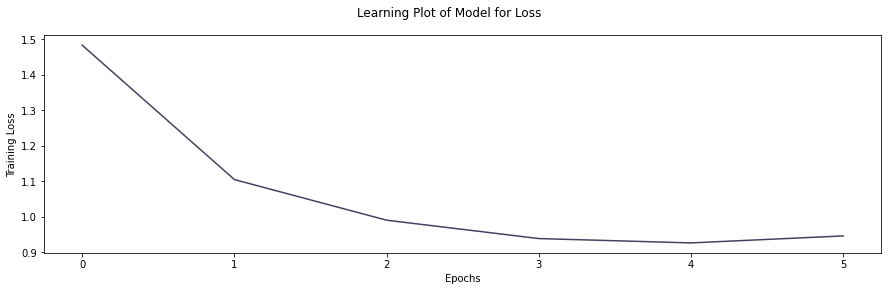

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")